### Creating a WAR metric from Statcast Stats

This notebook utilizes Statcast data from 2017 (the first year of Outs Above Average) onwards, in conjunction with Fangraphs' existing data, to create a wins above replacement metric based on Statcast defense stats, and xwOBA. Article writeup can be found here: 

In [1]:
import pandas as pd
from pandasql import sqldf
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')

In [2]:
#Function incoporates data from statcast, fangraphs, and a ID key to find WAR for a given year
#Data used can be found in the /data folder of the repository
def calculate_xwar(year, include_base_running = True):
    #Reading in the Expected Stats and Fangraphs Values
    x_stats = pd.read_csv('data/' + str(year) + '_expected_stats.csv')
    d_stats = pd.read_csv('data/' + str(year) + '_outs_above_average.csv')
    c_stats = pd.read_csv('data/' + str(year) + '_catcher_framing.csv').rename(columns={'fielder_2': 'player_id'})
    fg_values = pd.read_csv('data/' + str(year) + '_fg_value.csv').rename(columns={'playerid': 'fg_id'})
    id_map = pd.read_csv('data/playeridmap.csv', index_col = 'MLBID')
    #Baseline calculations and constants from Fangraphs' Guts
    guts = pd.read_csv('data/guts.csv', index_col = 'Season')
    avg_woba = guts.loc[year,'wOBA']
    avg_xwoba = guts.loc[year,'xWOBA']
    woba_scale = guts.loc[year,'wOBAScale']
    runs_per_win = guts.loc[year,'R/W']
    total_games = guts.loc[year,'GP']
    total_pa = sum(x_stats['pa'])
    replacement_level_coefficient = 570 * total_games/2430 * runs_per_win/total_pa
    #Calculating WRAA using xWOBA
    x_stats['xWRAA'] = (x_stats['est_woba'] - avg_xwoba)/woba_scale * x_stats['pa']
    #Merging the Catcher Framing and OAA Metrics from Statcast into the original DF
    join_stats = pd.merge(x_stats, d_stats, on='player_id', how='left')
    join_stats = pd.merge(join_stats, c_stats, on='player_id', how='left')
    #Creating a single defensive runs column based on whether player is catcher or not
    xdraa_list = []
    non_c = join_stats['fielding_runs_prevented'].tolist()
    c = join_stats['runs_extra_strikes'].tolist()
    for i in range(len(c)):
        def_runs = 0
        if c[i] == c[i]:
            def_runs += c[i]
        if non_c[i] == non_c[i]:
            def_runs += non_c[i]
        xdraa_list.append(def_runs)
    join_stats['xDRAA'] = xdraa_list
    join_stats['xDRAA'] = join_stats['xDRAA'].fillna(0)
    #Finding the Fangraphs ID for each player
    fg_id_list = []
    for mlb_id in join_stats['player_id']:
        try:
            fg_id_list.append(id_map.loc[float(mlb_id),'IDFANGRAPHS'])
        except KeyError:
            fg_id_list.append(None)
    join_stats['fg_id'] = fg_id_list
    #Reading in Names
    fn_list = []
    for i in range(len(join_stats)):
        f = (join_stats.loc[i,' first_name_x'][1:])
        l = join_stats.loc[i,'last_name_x']
        k = f + ' ' + l
        k = k.strip('\n')
        k = k.strip(' ')
        fn_list.append(k)
    join_stats['full_name'] = fn_list
    join_stats_reduced = join_stats[['last_name_x',' first_name_x','player_id', 'year_x', 'pa', 'bip', 'woba', 'est_woba',
       'est_woba_minus_woba_diff', 'xWRAA',
       'display_team_name', 'year_y', 'primary_pos_formatted', 'fielding_runs_prevented',
                           'outs_above_average', 'runs_extra_strikes', 'strike_rate',
       'xDRAA', 'fg_id', 'full_name']]
    #Merging...
    fg_values['full_name'] = fg_values['Name']
    big_df = pd.merge(join_stats_reduced,fg_values, on='full_name', how='left')
    for i in range(len(big_df)):
        #If the positional column returns null, recheck with Fangraphs Id instead of Name
        if big_df.loc[i,'Positional'] != big_df.loc[i,'Positional'] or big_df.loc[i,'full_name'] == "Jose Ramirez": #Jose was not cooperating
            for j in range(len(fg_values)):
                if str(big_df.loc[i,'fg_id_x']) == str(fg_values.loc[j,'fg_id']):
                    big_df.loc[i,'Positional'] = fg_values.loc[j,'Positional']
                    big_df.loc[i,'WAR'] = fg_values.loc[j,'WAR']
                    big_df.loc[i,'Base Running'] = fg_values.loc[j,'Base Running']
    big_df['xWAR'] = (big_df['xWRAA'] + big_df['xDRAA'] + big_df['Positional'] + big_df['pa'] * replacement_level_coefficient)/runs_per_win
    if include_base_running:
        big_df['xWAR'] = big_df['xWAR'] +  big_df['Base Running']/runs_per_win
    return big_df

In [3]:
#Finding the R^2 value from within each of the four datasets
for yr in [2017,2018,2019,2020]:
    df = calculate_xwar(yr)
    df = df.dropna(subset=['xWAR', 'WAR'])
    df.to_csv('output/' + str(yr) + '_xWAR_leaderboard.csv')
    print(r2_score(df['xWAR'],df['WAR']))

0.8159893695413529
0.8438585959532041
0.845543075389653
0.6535827267400248


In [4]:
#Creating dataframes for each year separately and then concatenating them
df_17 = calculate_xwar(2017)
df_18 = calculate_xwar(2018)
df_19 = calculate_xwar(2019)
df_20 = calculate_xwar(2020)
df = pd.concat([df_17,df_18,df_19,df_20])

In [5]:
#Creating subset and dropping null values
df = df[['full_name','pa','year_x','WAR','xWAR']].sort_values('xWAR', ascending = False).dropna()
df['xWAR'] = round(df['xWAR'], 2)
df.sort_values('xWAR')

,full_name,pa,year_x,WAR,xWAR
329,Jeff Mathis,244,2019,-2.1,-1.62
256,John Hicks,333,2019,-1.2,-1.56
76,Mark Trumbo,603,2017,-1.3,-1.53
129,Chris Davis,522,2018,-3.2,-1.30
140,Carlos Beltran,509,2017,-1.1,-1.28
273,Adam Rosales,312,2017,-0.3,-1.27
412,Meibrys Viloria,148,2019,-0.9,-1.27
244,Darwin Barney,362,2017,-0.5,-1.24
234,Stevie Wilkerson,361,2019,-0.6,-1.16
210,Dwight Smith,392,2019,-0.8,-1.16


In [6]:
#Finding biggest differences
df['Difference'] = df['WAR'] - df['xWAR']
df.sort_values('Difference', ascending = False)

,full_name,pa,year_x,WAR,xWAR,Difference
14,Alex Bregman,690,2019,8.5,5.31,3.19
94,Didi Gregorius,570,2017,4.1,1.10,3.00
42,Scooter Gennett,638,2018,4.5,1.64,2.86
161,Yasmani Grandal,482,2017,4.1,1.29,2.81
142,Zack Cozart,507,2017,5.0,2.21,2.79
154,Eduardo Nunez,491,2017,2.2,-0.48,2.68
136,Marwin Gonzalez,515,2017,4.0,1.36,2.64
6,Dee Strange-Gordon,695,2017,3.6,0.97,2.63
57,Matt Chapman,616,2018,6.6,4.25,2.35
79,Eddie Rosario,592,2018,3.5,1.22,2.28


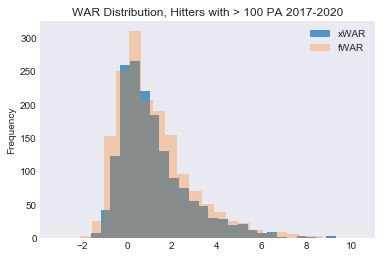

In [7]:
#Comparing distributions of fWAR and xWAR
df = sqldf("SELECT * FROM df WHERE pa > 100")
df.dropna(inplace=True)
df['xWAR'].plot(kind='hist', bins=25, alpha = .75)
df['WAR'].plot(kind='hist', bins=25, alpha = .3, label='fWAR')
plt.legend()
plt.title("WAR Distribution, Hitters with > 100 PA 2017-2020")
plt.show()

In [8]:
#finding predictiveness of xWAR on following year's fWAR
df_combined = pd.merge(df_18,df_19, on='player_id', how='left').dropna(subset=['xWAR_x', 'WAR_x', 'WAR_y'])
df_combined.reset_index(inplace=True)
df_1819 = df_combined[['full_name_x','pa_x','pa_y','xWAR_x', 'WAR_x', 'WAR_y']]
df_1819 = sqldf("SELECT * FROM df_1819 WHERE pa_x > 100 AND pa_y > 100")
r2_score(df_1819['WAR_x']/df_1819['pa_x'], df_1819['WAR_y']/df_1819['pa_y'])

-0.3789281999386871

In [9]:
df_combined = pd.merge(df_19,df_20, on='player_id', how='left').dropna(subset=['xWAR_x', 'WAR_x', 'WAR_y'])
df_combined.reset_index(inplace=True)
df_1920 = df_combined[['full_name_x','pa_x','pa_y','xWAR_x', 'WAR_x', 'WAR_y']]
df_1920 = sqldf("SELECT * FROM df_1920 WHERE pa_x > 100 AND pa_y > 75")
r2_score(df_1920['xWAR_x']/df_1920['pa_x'], df_1920['WAR_y']/df_1920['pa_y'])

-1.3646525066413857

In [45]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, Span
from bokeh.palettes import RdYlBu, RdYlGn
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.models.widgets import Panel, Tabs, DataTable, TableColumn
from bokeh.io.output import reset_output
from statistics import mean
import numpy as np

In [48]:
#Plotting xWAR vs fWAR within the same season
df = df_1819
names = df['full_name_x']

output_file("slider.html")

#X Variable - xWAR
list_x = df['xWAR_x']
x_label = '2018 xWAR'
#Y Variable - actual fWAR
list_y = df['WAR_x']
y_label = '2018 WAR'
#Color Scale
list_c = df['WAR_y']
color_label = '2019 WAR'
#Creating the description
desc = []
for i in range(len(names)):
    desc.append(str(names[i]) + ", " + color_label + ": " + str(round(list_c[i],3)))
#Color-Mapping the players to their WAR in 2019
mapper = LinearColorMapper(palette=RdYlGn[7], low=max(list_c), high=min(list_c))
#Making the hover tool and compiling the source data
source = ColumnDataSource(data=dict(x=list_x, y=list_y, c=list_c, desc=desc))
hover = HoverTool(tooltips=[
    ("(" + x_label + ", " + y_label + ")", "(@x, @y)"),
    ('Player', '@desc'),
])
#Creating trendline
par = np.polyfit(list_x, list_y, 1, full=True)
slope=par[0][0]
intercept=par[0][1]
y_predicted = [slope*i + intercept  for i in list_x]
#Plotting our data
p = figure(plot_width=950, plot_height=700,tools=[hover],
           title=x_label + " vs. " + y_label + " colored by " + color_label,
           x_axis_label=x_label,
           y_axis_label=y_label)
p.circle('x', 'y', size=19, source=source, fill_color={"field":"c", "transform":mapper})
# plot trendline
p.line(list_x,y_predicted,color='#b3b3b3', tags=['trendline'])
#Adding the plot to the first tab
tab1 = Panel(child=p, title="2018 xWAR vs fWAR")

In [49]:
#Same for 19-20 season into tab2
#Plotting xWAR vs fWAR within the same season
df = df_1920
names = df['full_name_x']

output_file("output/index.html")

#X Variable - xWAR
list_x = df['xWAR_x']
x_label = '2019 xWAR'
#Y Variable - actual fWAR
list_y = df['WAR_x']
y_label = '2019 WAR'
#Color Scale
list_c = df['WAR_y']
color_label = '2020 WAR'
#Creating the description
desc = []
for i in range(len(names)):
    desc.append(str(names[i]) + ", " + color_label + ": " + str(round(list_c[i],3)))
#Color-Mapping the players to their WAR in 2019
mapper = LinearColorMapper(palette=RdYlGn[7], low=max(list_c), high=min(list_c))
#Making the hover tool and compiling the source data
source = ColumnDataSource(data=dict(x=list_x, y=list_y, c=list_c, desc=desc))
hover = HoverTool(tooltips=[
    ("(" + x_label + ", " + y_label + ")", "(@x, @y)"),
    ('Player', '@desc'),
])
#Creating trendline
par = np.polyfit(list_x, list_y, 1, full=True)
slope=par[0][0]
intercept=par[0][1]
y_predicted = [slope*i + intercept  for i in list_x]
#Plotting our data
p = figure(plot_width=950, plot_height=700,tools=[hover],
           title=x_label + " vs. " + y_label + " colored by " + color_label,
           x_axis_label=x_label,
           y_axis_label=y_label)
p.circle('x', 'y', size=19, source=source, fill_color={"field":"c", "transform":mapper})
# plot trendline
p.line(list_x,y_predicted,color='#b3b3b3', tags=['trendline'])
#Adding the plot to the first tab
tab2 = Panel(child=p, title="2019 xWAR vs fWAR")

#show
tabs = Tabs(tabs=[ tab1, tab2 ])

show(tabs)

In [52]:
#Creating clickable Bokeh table

from bokeh.models.widgets import DataTable, TableColumn
year = 2017
table_tab_list = []
for y in [df_17, df_18, df_19, df_20]:
    tdf = y
    tdf = tdf[['last_name_x', ' first_name_x', 'year_x',
       'pa', 'woba', 'est_woba', 'display_team_name', 'primary_pos_formatted',
             'outs_above_average',
       'runs_extra_strikes',  'WAR', 'xWAR']]
    tdf.columns = ['Last', 'First', 'Year', 'PA', 'wOBA', 'xwOBA', 'Team', 'Pos.', 'OAA', 'R.E.S.', 'WAR', 'xWAR']
    tdf.sort_values('xWAR', inplace=True, ascending=False)
    tdf['xWAR'] = tdf.xWAR.apply(lambda x: round(x,1))
    tdf['ind'] = range(1, len(tdf) + 1)
    tdf.set_index('ind', inplace=True)
    Columns = [TableColumn(field=Ci, title=Ci) for Ci in tdf.columns] # bokeh columns
    data_table = DataTable(columns=Columns, source=ColumnDataSource(tdf)) # bokeh table
    tab = Panel(child=data_table, title=str(year) + " xWAR")
    table_tab_list.append(tab)
    year += 1

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel

In [53]:
t = Tabs(tabs=table_tab_list)

In [55]:
show(t)